# Spherical Top -- RK4
[RK4 method](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods) has been applied to a simple spherical top case (sphere).

--------------------------------

## Notes

1. Due to the $\csc\theta$ term, in $f_\phi = \omega_1\csc\theta\sin\psi + \omega_2\csc\theta\cos\psi$, we can't set the initial $\theta$, $\theta_0$, to be exactly zero. (related to the gimbal lock effect perhaps?) **[EJW: yes, exactly]**

2. In using [RK4 method](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods), for $f\left(t_n+\frac{h}{2}, y_n+\frac{k_1}{2}\right)$ terms, are we supposed to evaluate other time dependent terms, such as $\omega(t)$, at the next half time step as well? (My RK4 method only uses $\omega_n$, not $\omega_{n+\frac{1}{2}}$.) **[EJW: let me think about this]**

3. Any suggestions for testing the code? Right now, all it does is rotating about the vertical axis. I find it difficult to come up with a test since $\omega$'s involve more than one euler angles. Other test I did was to set $\omega3$ to be some positive constant. It rotates fater as expected. **[EJW: see below for sanity checks. More rigorous checks would involve comparing more than one resolution, step size. Or even better, compare error for more than one resolution, making sure error decreases with decreasing step size. One quantity worth monitoring is total energy, which in this case is just total kinetic energy. RK4 does not preserve energy conservation. If evolution is run for long enough, there will be a noticeable drift in energy. This becomes worse with larger step size.]**

4. I used my own rotation method/graphics, just to see if RK4 method works. Once things are improved, it needs to be patched onto the [animation](https://github.com/ejwest2/Rotation/blob/master/animation.ipynb) file. **[EJW: great, fine]**

5. Next step, force-free symmetric tops using numerical methods. **[EJW: yes, see below for sanity checks]**

## Sanity checks for force-free motion (no external torque)

Spherical top ($I_{1}=I_{2}=I_{3}$):

- rotate about z-axis (in the space frame) --> steady rotation? YES
- rotate about x- and y-axes (in the space frame) --> steady rotation?
- rotate about random axis --> steady rotation?

Symmetric top ($I_{1}=I_{2}\neq I_{3}$):

- rotate about x-, y-, or z-axes (in the space frame) --> steady rotation?
- rotate about random axis in xy-plane --> steady rotation?
- rotate about random axis out of xy-plane --> precession about z-axis (oscillation in $\omega_{1}$ and $\omega_{2}$, but steady motion for $\omega_{3}$)?

Asymmetric top ($I_{1} < I_{2} < I_{3}$):

- rotate about x-, y-, or z-axes (in the space frame) --> steady rotation?
- rotate about axis near z-axis (major axis) --> sinusoidal oscillation in $\omega_{1}$ and $\omega_{2}$, no oscillation in $\omega_{3}$?
- rotate about axis near x-axis (minor axis) --> sinusoidal oscillation in $\omega_{2}$ and $\omega_{3}$, no oscillation in $\omega_{1}$?
- rotate about axis near y-axis (intermediate axis) --> non-sinusoidal oscillation in all three $\omega$'s (occasional "flip" of precession axis, ala eraser toss)


In [1]:
%matplotlib notebook
import math
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d

In [2]:
# main parameters

# here the radius R, and I are arbirtrary
R = 10  
I = 10

# consider torque free
N1= 0
N2 = 0
N3 = 0

Np = 100  # number of points

# initalization
w1 = np.zeros(Np)
w2 = np.zeros(Np)
w3 = np.zeros(Np)
w3[0] = 0.5   # assign non-zero constant w3 to avoid trivial solutions

Phi = np.zeros(Np)
Theta = np.zeros(Np)
Psi = np.zeros(Np)
Phi[0] = 0
Theta[0] = 0.001   # the expression doesnt allow the initial theta to be zero
Psi[0] = 0

# technically we only need dt
t = np.linspace(0, 10*2*np.pi, Np)
dt = t[1]-t[0]

In [3]:
# other parameters
tilt = 23.5*np.pi/180   # tilt angle

# meshgrids
lat0 = np.linspace(0, np.pi, Np)
lon0 = np.linspace(0, 2*np.pi, Np)
lat, lon = np.meshgrid(lat0, lon0)

# initial x,y,z
x0 = R*np.sin(lat)*np.cos(lon)
y0 = R*np.sin(lat)*np.sin(lon)
z0 = R*np.cos(lat)

# default axis
p0 = np.array([0, 0, R])
#p0, x0, y0, z0 = evolve(0, tilt, 0)

In [4]:
# RK4 for w1 equation
def rk4w1(n):
    
    k1 = dt*N1/I
    k2 = dt*N1/I
    k3 = dt*N1/I
    k4 = dt*N1/I
    
    w1New = w1[n] + 1/6*(k1 + 2*k2 + 2*k3 + k4)
    
    return w1New

In [5]:
# RK4 for w2 equation
def rk4w2(n):
    
    k1 = dt*N2/I
    k2 = dt*N2/I
    k3 = dt*N2/I
    k4 = dt*N2/I
    
    w2New = w2[n] + 1/6*(k1 + 2*k2 + 2*k3 + k4)
    
    return w2New

In [6]:
# RK4 for w3 equation
def rk4w3(n):
    
    k1 = dt*N3/I
    k2 = dt*N3/I
    k3 = dt*N3/I
    k4 = dt*N3/I
    
    w3New = w3[n] + 1/6*(k1 + 2*k2 + 2*k3 + k4)
    
    return w3New

In [7]:
# RK4 for Phi equation
def rk4Phi(n):
    
    def fPhi(n):
        f = 1/np.sin(Theta[n])*(w1[n]*np.sin(Psi[n]) + w2[n]*np.cos(Psi[n]))
        return f
    
    k1 = dt*fPhi(n)
    k2 = dt*fPhi(n)
    k3 = dt*fPhi(n)
    k4 = dt*fPhi(n)
    
    phiNew = Phi[n] + 1/6*(k1 + 2*k2 + 2*k3 + k4)
    
    return phiNew   

In [8]:
# RK4 for Theta equation
def rk4Theta(n):
    
    def fTheta(n):
        f = w1[n]*np.cos(Psi[n]) - w2[n]*np.sin(Psi[n])
        return f
    
    k1 = dt*fTheta(n)
    k2 = dt*fTheta(n)
    k3 = dt*fTheta(n)
    k4 = dt*fTheta(n)
    
    thetaNew = Theta[n] + 1/6*(k1 + 2*k2 + 2*k3 + k4)
    
    return thetaNew   

In [9]:
# RK4 for Psi equation
def rk4Psi(n):
    
    def fPsi(n):
        f = -w1[n]*np.sin(Psi[n])/np.tan(Theta[n]) - w2[n]*np.cos(Psi[n])/np.tan(Theta[n]) + w3[n]
        return f
    
    k1 = dt*fPsi(n)
    k2 = dt*fPsi(n)
    k3 = dt*fPsi(n)
    k4 = dt*fPsi(n)
    
    psiNew = Psi[n] + 1/6*(k1 + 2*k2 + 2*k3 + k4)
    
    return psiNew   

In [10]:
# updates the meshgrids using the rotation matix at each step
def evolve(phi, theta, psi):
    
    # rotation matrix -- euler angles
    rotMat = np.array([[np.cos(psi)*np.cos(phi)-np.cos(theta)*np.sin(phi)*np.sin(psi), np.cos(psi)*np.sin(phi)+np.cos(theta)*np.cos(phi)*np.sin(psi), np.sin(psi)*np.sin(theta)], \
                    [-np.sin(psi)*np.cos(phi)-np.cos(theta)*np.sin(phi)*np.cos(psi), -np.sin(psi)*np.sin(phi)+np.cos(theta)*np.cos(phi)*np.cos(psi), np.cos(psi)*np.sin(theta)], \
                    [np.sin(theta)*np.sin(phi), -np.sin(theta)*np.cos(phi), np.cos(theta)]])
    
    # rotate meshgrid
    xNew = np.zeros([Np,Np])
    yNew = np.zeros([Np,Np])
    zNew = np.zeros([Np,Np])
    for i in range(Np):
        for j in range(Np):
            xNew[i,j] = rotMat[0,0]*x0[i,j] + rotMat[0,1]*y0[i,j] + rotMat[0,2]*z0[i,j]
            yNew[i,j] = rotMat[1,0]*x0[i,j] + rotMat[1,1]*y0[i,j] + rotMat[1,2]*z0[i,j]
            zNew[i,j] = rotMat[2,0]*x0[i,j] + rotMat[2,1]*y0[i,j] + rotMat[2,2]*z0[i,j]
    
    # rotate axis
    pNew = np.dot(rotMat, p0)
    
    return pNew, xNew, yNew, zNew

In [11]:
def plotSphere(p, x, y, z):
    
    # evolve grids
    ax0.set_xlim(-1.3*R, 1.3*R)
    ax0.set_ylim(-1.3*R, 1.3*R)
    ax0.set_zlim(-1.3*R, 1.3*R)
    
    # highlighted strip to see the rotation/spin more easily
    N0 = int(Np/20)
    ax0.plot_surface(x[N0:], y[N0:], z[N0:], color='lightskyblue', alpha=0.8)
    ax0.plot_surface(x[:N0+1], y[:N0+1], z[:N0+1], color='mediumseagreen', alpha=0.8)

    # evolve axis
    ax0.plot([-1.3*p[0],-p[0]], [-1.3*p[1],-p[1]], [-1.3*p[2],-p[2]], color='darkgreen', linewidth=1)
    ax0.plot([-p[0],p[0]], [-p[1],p[1]], [-p[2],p[2]], color='darkgreen', linestyle='--', linewidth=1)
    ax0.plot([p[0],1.3*p[0]], [p[1],1.3*p[1]], [p[2],1.3*p[2]], color='darkgreen', linewidth=1)
    
    return        

In [12]:
# evolve with time

for n in range(Np-1):   # notice Np-1 due to the nature of the RK4 method
    
    w1[n+1] = rk4w1(n)
    w2[n+1] = rk4w2(n)
    w3[n+1] = rk4w3(n)
    
    Phi[n+1] = rk4Phi(n)
    Theta[n+1] = rk4Theta(n)
    Psi[n+1] = rk4Psi(n)    

<IPython.core.display.Javascript object>


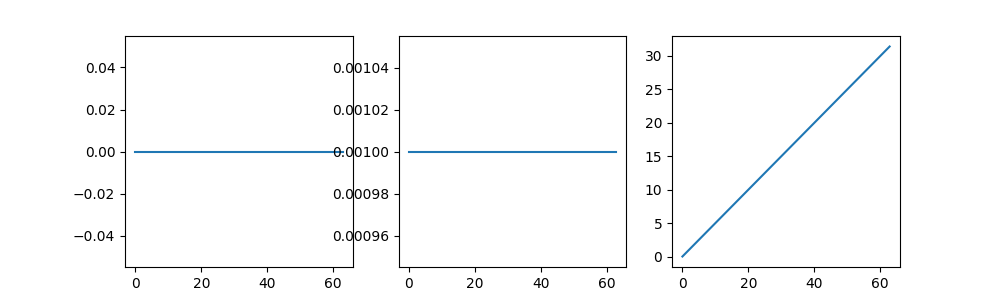

In [13]:
# fig1 shows euler angles

fig1 = plt.figure(figsize=(10,3))
#ax0 =fig0.add_subplot(111, projection='3d')
ax0 =fig1.add_subplot(131)
ax1 =fig1.add_subplot(132)
ax2 =fig1.add_subplot(133)

ax0.plot(t,Phi)
ax1.plot(t,Theta)
ax2.plot(t,Psi)

<IPython.core.display.Javascript object>


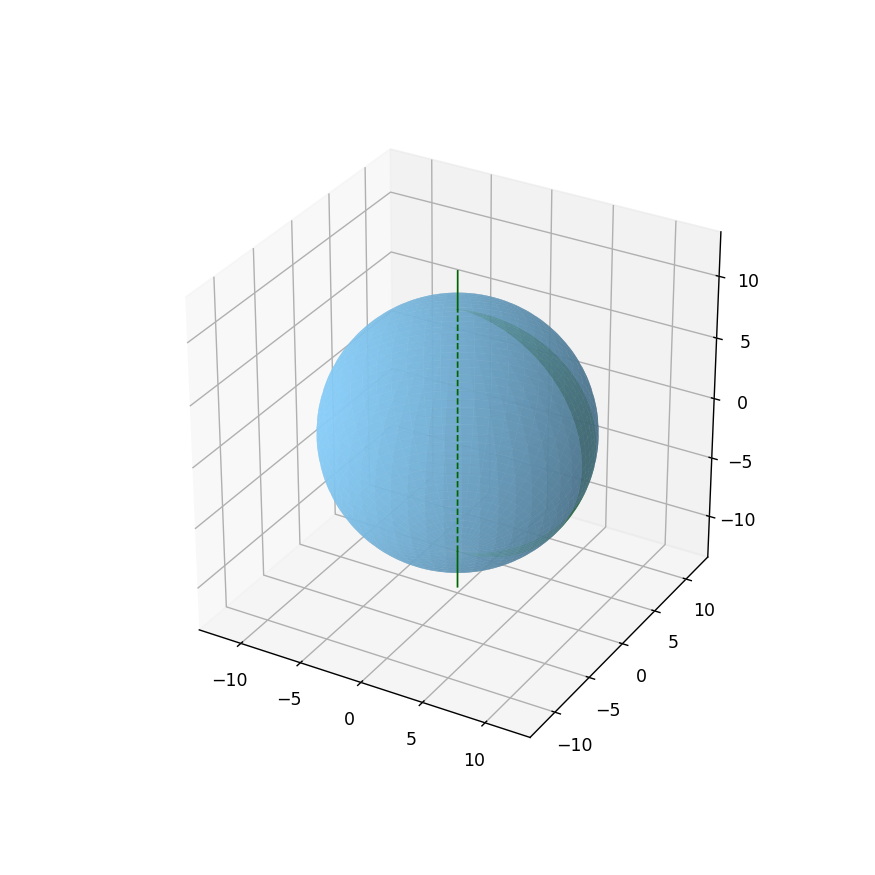

In [45]:
# prepare a figure
fig0 = plt.figure(figsize=(7,7))
ax0 =fig0.add_subplot(111, projection='3d')

for n in range(Np):
    
    # evolve
    p, x, y, z = evolve(Phi[n], Theta[n], Psi[n])
    
    # update figure
    ax0.clear()
    plotSphere(p, x, y, z)
    fig0.canvas.draw()